In [2]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

# Setup the module path that contains the framework code
from pathlib import Path
module_path = str(Path.cwd())
if module_path not in sys.path:
    sys.path.append(module_path)

# Import the libraries
from modules.DataOperations import *
from modules.DataProcessing import *
from modules.MachineLearner import *

In [3]:
inc_data_path = 'data/inc_count.csv'
pop_data_path = 'data/pop.csv'
env_data_path = 'data/env_data_dict.npy'
win_data_path = 'data/win_analysis/'

In [4]:
#  for each ic, for each win_scheme, for each model find improvement over no pic error with the optimum pic error
def find_improvemnts_over_no_pic(win_error_dict):
    metric_index = 1
    win_keys = list(win_error_dict.keys())
    win_opt_dict = {}
    
    for w_key in win_keys:
        win_opt_df = pd.DataFrame()

        linear_opt_error = []
        lstm_opt_error = []
        gru_opt_error = []
        
        linear_base_error = []
        lstm_base_error = []
        gru_base_error = []
        
        ic_list = list(win_error_dict[w_key].keys())

        for target_loc in ic_list:
            test_errors = win_error_dict[w_key][target_loc]
            linear_errors = []
            lstm_errors = []
            gru_errors = []
            error_df = pd.DataFrame()
            
            feature_counts = list(test_errors.keys())

            for nPIC in feature_counts:
                linear_errors.append(test_errors[nPIC]['Linear'][metric_index])
                lstm_errors.append(test_errors[nPIC]['LSTM'][metric_index])
                gru_errors.append(test_errors[nPIC]['GRU'][metric_index])

            error_df['nFeat'] = feature_counts
            error_df['linear'] = linear_errors
            error_df['lstm'] = lstm_errors
            error_df['gru'] = gru_errors
            error_df = error_df.set_index('nFeat')
            

            opt_error = error_df.min()
            no_pic_error = error_df.loc[0]
            
            linear_opt_error.append(opt_error.linear)
            lstm_opt_error.append(opt_error.lstm)
            gru_opt_error.append(opt_error.gru)
            
            linear_base_error.append(no_pic_error.linear)
            lstm_base_error.append(no_pic_error.lstm)
            gru_base_error.append(no_pic_error.gru)

        win_opt_df['ic'] = ic_list
        win_opt_df = win_opt_df.set_index('ic')
        win_opt_df['linear_base_error'] = linear_base_error
        win_opt_df['lstm_base_error'] = lstm_base_error
        win_opt_df['gru_base_error'] = gru_base_error
        win_opt_df['linear_opt_error'] = linear_opt_error
        win_opt_df['lstm_opt_error'] = lstm_opt_error
        win_opt_df['gru_opt_error'] = gru_opt_error
        
        win_opt_df["linear_improve"] = -(win_opt_df["linear_opt_error"]-win_opt_df["linear_base_error"])/win_opt_df["linear_base_error"]
        win_opt_df["lstm_improve"] = -(win_opt_df["lstm_opt_error"]-win_opt_df["lstm_base_error"])/win_opt_df["lstm_base_error"]
        win_opt_df["gru_improve"] = -(win_opt_df["gru_opt_error"]-win_opt_df["gru_base_error"])/win_opt_df["gru_base_error"]
        
        win_opt_dict[w_key] = win_opt_df
    
    
    return win_opt_dict

def get_summary_stat(win_opt_dict, not_working_ic_list):
    linear_opt_error = []
    lstm_opt_error = []
    gru_opt_error = []
    
    linear_opt_error_sem = []
    lstm_opt_error_sem = []
    gru_opt_error_sem = []

    linear_improve = []
    lstm_improve = []
    gru_improve = []

    linear_improve_sem = []
    lstm_improve_sem = []
    gru_improve_sem = []
    
    for w_key in win_opt_dict.keys():
        win_opt_df = win_opt_dict[w_key]

        working_ic_list = [x for x in win_opt_df.index.values if x not in not_working_ic_list]

        mean_opt_stat = win_opt_df.loc[working_ic_list].mean()
        sem_opt_stat = win_opt_df.loc[working_ic_list].sem()
        
        linear_opt_error.append(mean_opt_stat.linear_opt_error)
        lstm_opt_error.append(mean_opt_stat.lstm_opt_error)
        gru_opt_error.append(mean_opt_stat.gru_opt_error)
        
        linear_opt_error_sem.append(sem_opt_stat.linear_opt_error)
        lstm_opt_error_sem.append(sem_opt_stat.lstm_opt_error)
        gru_opt_error_sem.append(sem_opt_stat.gru_opt_error)

        linear_improve.append(mean_opt_stat.linear_improve)
        lstm_improve.append(mean_opt_stat.lstm_improve)
        gru_improve.append(mean_opt_stat.gru_improve)

        linear_improve_sem.append(sem_opt_stat.linear_improve)
        lstm_improve_sem.append(sem_opt_stat.lstm_improve)
        gru_improve_sem.append(sem_opt_stat.gru_improve)
    
    
    opt_error_list = [linear_opt_error, lstm_opt_error, gru_opt_error]
    opt_error_sem_list = [linear_opt_error_sem, lstm_opt_error_sem, gru_opt_error_sem]
    improve_list = [linear_improve, lstm_improve, gru_improve]
    improve_sem_list = [linear_improve_sem, lstm_improve_sem, gru_improve_sem]
    
    return opt_error_list, opt_error_sem_list, improve_list, improve_sem_list

def plot_mean_performance_improvements(improve_df, sem_df):

    improve_df = improve_df*100
    sem_df = sem_df*100
    
    x = np.arange(3) # + len(d_opt_error_dict)
    model_labels = ['Linear', 'LSTM', 'GRU']
    
    width = 0.1
    plt.figure(num=None, figsize=(14,10))
    
    
    df_indices = improve_df.index.values
    xOffset = np.linspace(-0.35,0.35,8)
    markerFmts = ['o', '<', 's', '*', 'p', 'x', 'D', '^']
    labelArray = ['Fixed, $M^f$ = 5', 'Fixed, $M^f$ = 10', 'Fixed, $M^f$ = 20', 'Fixed, $M^f$ = 40', 'Detected, $\Delta_{MIN}$ = 5', 'Detected, $\Delta_{MIN}$ = 10', 'Detected, $\Delta_{MIN}$ = 20', 'Detected, $\Delta_{MIN}$ = 30']
    
    for i in range(len(df_indices)):
        plt.errorbar(x+xOffset[i], improve_df.loc[df_indices[i]].values, yerr=sem_df.loc[df_indices[i]].values, fmt=markerFmts[i], markersize = 10, elinewidth=1, capsize=5, capthick=1, label= labelArray[i])
    
    plt.xticks(ticks=x, labels=model_labels)
    plt.ylim([0,70])
    plt.xlabel('Prediction Models')
    plt.ylabel('Mean improvement in Accuracy (%)')
    plt.legend(loc='upper right', ncol = 2)
#     plt.savefig('exports/predictions/window_methods/mean_improvements.svg')

def plot_mean_optimal_errors(opt_error_df, sem_df):
    
    x = np.arange(3) # + len(d_opt_error_dict)
    model_labels = ['Linear', 'LSTM', 'GRU']
    
    width = 0.1
    plt.figure(num=None, figsize=(14,10))
    
    
    df_indices = opt_error_df.index.values
    xOffset = np.linspace(-0.35,0.35,8)
    markerFmts = ['o', '<', 's', '*', 'p', 'x', 'D', '^']
    labelArray = ['Fixed, $M^f$ = 5', 'Fixed, $M^f$ = 10', 'Fixed, $M^f$ = 20', 'Fixed, $M^f$ = 40', 'Detected, $\Delta_{MIN}$ = 5', 'Detected, $\Delta_{MIN}$ = 10', 'Detected, $\Delta_{MIN}$ = 20', 'Detected, $\Delta_{MIN}$ = 30']
    
    for i in range(len(df_indices)):
        plt.errorbar(x+xOffset[i], opt_error_df.loc[df_indices[i]].values, yerr=sem_df.loc[df_indices[i]].values, fmt=markerFmts[i], markersize = 10, elinewidth=1, capsize=5, capthick=1, label= labelArray[i])
    
    plt.xticks(ticks=x, labels=model_labels)
    plt.ylim([0,1.5])
    plt.xlabel('Prediction Models')
    plt.ylabel('Mean optimal MAE')
    plt.legend(loc='upper right', ncol = 2)
#     plt.savefig('exports/predictions/window_methods/mean_opt_mae.svg')

In [ ]:
# region_id = 'ES'
# loc_data = get_brazil_location_data()
# locs_in_region_with_data = get_regional_locations(region_id, loc_data)
# inc_count_df = get_data_for_locs(locs_in_region_with_data)
# inc_count_df = inc_count_df[inc_count_df['date'] < '2020-08-23']

## Store the data read from the database
## inc_count_df.to_csv(inc_data_path, index=False)

In [5]:
inc_count_df = pd.read_csv(inc_data_path)
inc_count_df['date'] = pd.to_datetime(inc_count_df['date'])
inc_count_df.iloc[:, 1:] = inc_count_df.iloc[:, 1:].apply(pd.to_numeric)

outbreak_sizes = inc_count_df.sum().sort_values(ascending = False)

In [ ]:
# pop_df = get_population_data(locs_in_region_with_data)

## Store the data read from the database
# pop_df.to_csv(pop_data_path, index=True)

In [6]:
pop_df = pd.read_csv(pop_data_path, index_col=0)

inc_ratio_df = normalize_case_counts(inc_count_df, pop_df)
outbreak_ratios = inc_ratio_df.sum().sort_values(ascending = False)
add_case_counts(pop_df, outbreak_sizes, outbreak_ratios)

In [7]:
# Parameters: correlation window
max_shift = 15
comp_win_ext = 4
phase_ext = 1
min_corr = 0.1

# Parameters: sorting predictors
sort_options = {}
sort_options['corr_weight'] = True
sort_options['dist_weight'] = True
sort_options['prev_weight'] = True
sort_options['prev_type'] = 'relative'

# Parameters: prediction model
output_steps = 4
input_steps = 8

split_frac = [.5, .3, .2]
iterations = 150
verbosity = 0


# parameters: IC and PIC selection
ic_list = outbreak_ratios[0:20].index #outbreak_sizes[0:10].index

feature_counts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 20, 25, 30]

In [9]:
# env_data_dict = {}

# idx = 1
# for target_loc in ic_list:
    
#     print(f'Progress: IC number {idx} of {len(ic_list)}')
    
#     print(f'Target location id: {target_loc}')
    
#     lat, lon = get_loc_coord(target_loc)
#     print(f'Location coordinates (lat, lon): {lat}, {lon}')
    
#     # Get weather data
#     print('Obtaining weather station data ...')
#     daily_obs_df, dist = get_station_data(lat, lon, search_range=250, urlStation='http://10.135.76.81:3254/stations', urlObs='http://10.135.76.81:3254/observations', fromDate=inc_ratio_df['date'].min().date(), toDate=inc_ratio_df['date'].max().date(), tol=0.1)
    
#     # Convert to match the incidence data
#     Weather_obs_df = convert_weather_to_weekly(inc_ratio_df['date'], daily_obs_df)
    
#     # Get reanalysis data
#     print('Obtaining reanalysis data ...')
#     Reanalysis_df = get_rean_data(lat, lon, inc_ratio_df['date'])
#     obs_rean_df = pd.merge(Weather_obs_df, Reanalysis_df, how='outer', on='date')
#     env_data_dict[target_loc] = obs_rean_df
#     idx = idx + 1

# np.save('exports/raw/win_anal/env_data_dict.npy', env_data_dict)

In [8]:
env_data_dict = np.load(env_data_path, allow_pickle='TRUE').item()

In [ ]:
# # For fixed window sizes, vary data_splits
# # fixed window
# data_splits = [5,10,20,40]

# fixed_win_ranked_pic_dict = {}
# fixed_win_error_dict = {}

# fixed_win_optimal_feat_dict = {}

# idx_w = 1
# for no_of_windows in data_splits:
#     print('The number of windows to used: ' + str(no_of_windows))
    
#     ranked_pic_dict = {}
#     test_error_dict = {}
    
#     optimal_feat_list = []
    
#     idx_ic = 1
#     for target_loc in ic_list:
#         print(f'Target location id: {target_loc}')
        
#         print(f'Progress: Window {idx_w} of {len(data_splits)}, IC {idx_ic} of {len(ic_list)}')
        
#         obs_rean_df = env_data_dict[target_loc]

#         print('Computing predictabilities')
#         pic_predictabilities = compute_predictability(ic_id = str(target_loc), inc_df = inc_ratio_df, lag_weeks = max_shift, no_of_windows = no_of_windows, side_len = comp_win_ext, min_corr = min_corr, extend_phase = phase_ext)
        
#         ranked_pics = sort_predictors(pic_predictabilities, pop_df, int(target_loc), sort_options)
#         ranked_pic_dict[target_loc] = ranked_pics

#         print('Running ML fitting and evaluations')
#         test_errors, forecast_windows, linear_models, lstm_models, gru_models = run_ml_predictions(target_loc, obs_rean_df, inc_ratio_df, ranked_pics, feature_counts, split_frac, input_steps, output_steps, iterations, verbosity)
        
#         test_error_dict[target_loc] = test_errors
        
#         min_errors = find_best_performers(feature_counts, test_errors, 1)
#         min_errors['loc_id'] = target_loc

#         optimal_feat_dict = {}
#         optimal_feat_dict.update(min_errors)
#         optimal_feat_list.append(optimal_feat_dict)
#         idx_ic = idx_ic + 1
    
#     fixed_win_ranked_pic_dict[no_of_windows] = ranked_pic_dict
#     fixed_win_error_dict[no_of_windows] = test_error_dict
    
#     optimal_features_df = pd.DataFrame(optimal_feat_list)
#     optimal_features_df.columns = ['linear', 'lstm', 'gru', 'loc_id']
#     optimal_features_df = optimal_features_df.set_index('loc_id')
    
#     fixed_win_optimal_feat_dict[no_of_windows] = optimal_features_df
    
#     idx_w = idx_w + 1

# # save simulation results in storage
# np.save(win_data_path+'fixed_win_ranked_pic_dict.npy', fixed_win_ranked_pic_dict)
# np.save(win_data_path+'fixed_win_error_dict.npy', fixed_win_error_dict)
# np.save(win_data_path+'fixed_win_optimal_feat_dict.npy', fixed_win_optimal_feat_dict)

In [9]:
# load simulation results from storage
fixed_win_ranked_pic_dict = np.load(win_data_path+'fixed_win_ranked_pic_dict.npy', allow_pickle='TRUE').item()
fixed_win_error_dict = np.load(win_data_path+'fixed_win_error_dict.npy', allow_pickle='TRUE').item()
fixed_win_optimal_feat_dict = np.load(win_data_path+'fixed_win_optimal_feat_dict.npy', allow_pickle='TRUE').item()

In [ ]:
# # For window detection process, vary minimum window_len (5, 10 weeks, 20 weeks, 30 weeks)
# # window detection parameters
# risk_min = 0.05
# min_win_lengths = [5, 10, 20, 30]

# det_win_ranked_pic_dict = {}
# det_win_error_dict = {}

# det_win_optimal_feat_dict = {}

# idx_w = 1
# for min_win_len in min_win_lengths:
#     print('For minimum window length of: ' + str(min_win_len))
    
#     ranked_pic_dict = {}
#     test_error_dict = {}
    
#     optimal_feat_list = []
    
#     idx_ic = 1
#     for target_loc in ic_list:
        
#         print(f'Target location id: {target_loc}')
        
#         print(f'Progress: Window {idx_w} of {len(min_win_lengths)}, IC {idx_ic} of {len(ic_list)}')
        
#         obs_rean_df = env_data_dict[target_loc]

#         print('Computing predictabilities')
#         pic_predictabilities = compute_var_window_predictability(ic_id = str(target_loc), inc_df = inc_ratio_df, lag_weeks = max_shift, min_win_len=min_win_len, risk_min=risk_min, side_len = comp_win_ext, min_corr = min_corr, extend_phase = phase_ext)
        
#         if pic_predictabilities.empty:
#             print('No windows were detected!')
#             continue
        
#         ranked_pics = sort_predictors(pic_predictabilities, pop_df, int(target_loc), sort_options)
#         ranked_pic_dict[target_loc] = ranked_pics


#         print('Running ML fitting and evaluations')
#         test_errors, forecast_windows, linear_models, lstm_models, gru_models = run_ml_predictions(target_loc, obs_rean_df, inc_ratio_df, ranked_pics, feature_counts, split_frac, input_steps, output_steps, iterations, verbosity)
        
#         test_error_dict[target_loc] = test_errors
        
#         min_errors = find_best_performers(feature_counts, test_errors, 1)
#         min_errors['loc_id'] = target_loc

#         optimal_feat_dict = {}
#         optimal_feat_dict.update(min_errors)
#         optimal_feat_list.append(optimal_feat_dict)
        
#         idx_ic = idx_ic + 1
    
#     det_win_ranked_pic_dict[min_win_len] = ranked_pic_dict
#     det_win_error_dict[min_win_len] = test_error_dict
    
#     optimal_features_df = pd.DataFrame(optimal_feat_list)
#     optimal_features_df.columns = ['linear', 'lstm', 'gru', 'loc_id']
#     optimal_features_df = optimal_features_df.set_index('loc_id')
    
#     det_win_optimal_feat_dict[min_win_len] = optimal_features_df
    
#     idx_w = idx_w + 1

# # save simulation results in storage
# np.save(win_data_path+'det_win_ranked_pic_dict.npy', det_win_ranked_pic_dict)
# np.save(win_data_path+'det_win_error_dict.npy', det_win_error_dict)
# np.save(win_data_path+'det_win_optimal_feat_dict.npy', det_win_optimal_feat_dict)

In [10]:
# load simulation results from storage
det_win_ranked_pic_dict = np.load(win_data_path+'det_win_ranked_pic_dict.npy', allow_pickle='TRUE').item()
det_win_error_dict = np.load(win_data_path+'det_win_error_dict.npy', allow_pickle='TRUE').item()
det_win_optimal_feat_dict = np.load(win_data_path+'det_win_optimal_feat_dict.npy', allow_pickle='TRUE').item()

In [11]:
not_working_ic_list = ['3201100', '3203106', '3204252', '3203205']
opt_cols = ['linear_opt_error', 'lstm_opt_error', 'gru_opt_error']

linear_opt_error = []
lstm_opt_error = []
gru_opt_error = []

linear_opt_error_sem = []
lstm_opt_error_sem = []
gru_opt_error_sem = []

linear_improve = []
lstm_improve = []
gru_improve = []

linear_improve_sem = []
lstm_improve_sem = []
gru_improve_sem = []

win_scheme = []

win_opt_dict = find_improvemnts_over_no_pic(fixed_win_error_dict)
win_scheme = ['mf ' + str(x) for x in list(win_opt_dict.keys())]

opt_error_list, opt_error_sem_list, improve_list, improve_sem_list = get_summary_stat(win_opt_dict, not_working_ic_list)

linear_opt_error += opt_error_list[0]
lstm_opt_error += opt_error_list[1]
gru_opt_error += opt_error_list[2]

linear_opt_error_sem += opt_error_sem_list[0]
lstm_opt_error_sem += opt_error_sem_list[1]
gru_opt_error_sem += opt_error_sem_list[2]

linear_improve += improve_list[0]
lstm_improve += improve_list[1]
gru_improve +=improve_list[2]

linear_improve_sem += improve_sem_list[0]
lstm_improve_sem += improve_sem_list[1]
gru_improve_sem += improve_sem_list[2]

win_opt_dict = find_improvemnts_over_no_pic(det_win_error_dict)
win_scheme = win_scheme + ['dm ' + str(x) for x in list(win_opt_dict.keys())]

opt_error_list, opt_error_sem_list, improve_list, improve_sem_list = get_summary_stat(win_opt_dict, not_working_ic_list)

linear_opt_error += opt_error_list[0]
lstm_opt_error += opt_error_list[1]
gru_opt_error += opt_error_list[2]

linear_opt_error_sem += opt_error_sem_list[0]
lstm_opt_error_sem += opt_error_sem_list[1]
gru_opt_error_sem += opt_error_sem_list[2]

linear_improve += improve_list[0]
lstm_improve += improve_list[1]
gru_improve +=improve_list[2]

linear_improve_sem += improve_sem_list[0]
lstm_improve_sem += improve_sem_list[1]
gru_improve_sem += improve_sem_list[2]

opt_error_df = pd.DataFrame()
opt_error_df['schemes'] = win_scheme

opt_error_df['linear'] = linear_opt_error
opt_error_df['lstm'] = lstm_opt_error
opt_error_df['gru'] = gru_opt_error

opt_error_df['linear_sem'] = linear_opt_error_sem
opt_error_df['lstm_sem'] = lstm_opt_error_sem
opt_error_df['gru_sem'] = gru_opt_error_sem

opt_error_df.set_index('schemes', inplace=True)


improve_df = pd.DataFrame()
improve_df['schemes'] = win_scheme

improve_df['linear_improve'] = linear_improve
improve_df['lstm_improve'] = lstm_improve
improve_df['gru_improve'] = gru_improve

improve_df['linear_sem'] = linear_improve_sem
improve_df['lstm_sem'] = lstm_improve_sem
improve_df['gru_sem'] = gru_improve_sem

improve_df.set_index('schemes', inplace=True)

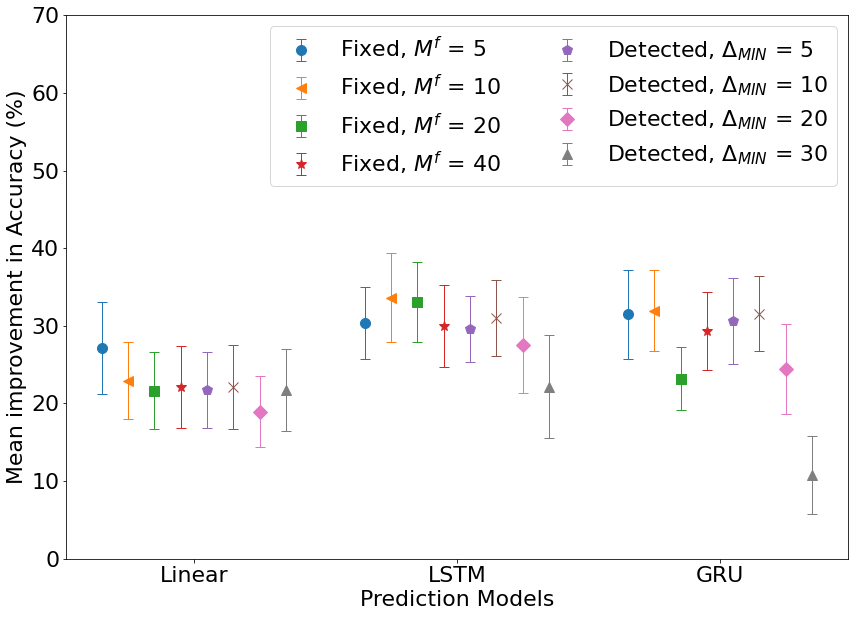

In [12]:
plot_mean_performance_improvements(improve_df[['linear_improve', 'lstm_improve', 'gru_improve']], improve_df[['linear_sem', 'lstm_sem', 'gru_sem']])

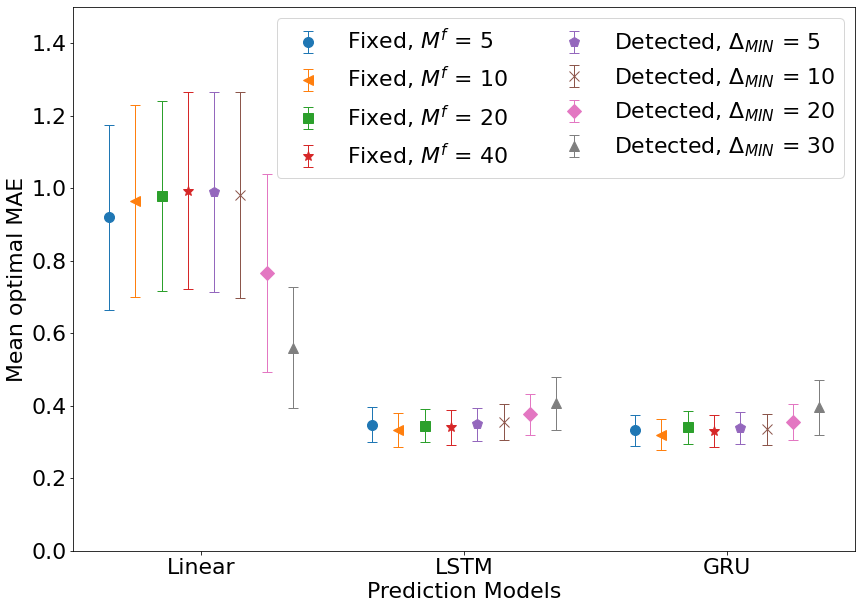

In [13]:
plot_mean_optimal_errors(opt_error_df[['linear', 'lstm', 'gru']], opt_error_df[['linear_sem', 'lstm_sem', 'gru_sem']])